## Adaboost from scratch

In [73]:
from __future__ import division, print_function
import numpy as np
import math


class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        self.alpha = None

class Adaboost():
    def __init__(self, n_clf=20):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)
        w = np.full(n_samples, (1 / n_samples))
        self.clfs = []
        y[y==0] = -1
        
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float('inf')
            for feature_i in range(n_features):
                unique_values = np.unique(X[:, feature_i])
                for threshold in unique_values:
                    p = 1
                    prediction = np.ones(np.shape(y))
                    prediction[X[:, feature_i] < threshold] = -1
                    error = sum(w[y != prediction])
                    
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
                    
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            predictions = np.ones(np.shape(y))
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            predictions[negative_idx] = -1
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))

        for clf in self.clfs:
            predictions = np.ones(np.shape(y_pred))
            negative_idx = (X[:, clf.feature_index] < clf.threshold)
            predictions[negative_idx] = -1
            y_pred += clf.alpha * predictions
        y_pred = (np.sign(y_pred).flatten() + 1)/2

        return y_pred

In [74]:
X = np.array([[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7]]).T
y = np.array([0, 0, 0, 1, 1, 1])
X_t=np.array([[2,1],[7,8]])

AB = Adaboost()
AB.fit(X, y)
AB.predict(X_t)

array([ 0.,  1.])

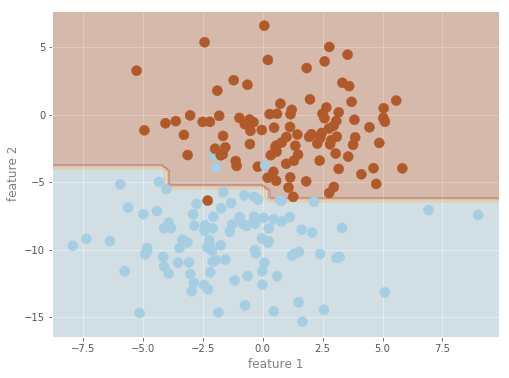

In [75]:
## Model and visulization

from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X_train, y_train = make_blobs(n_samples=200, centers=2,
                  random_state=2, cluster_std=2.50)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel('feature 1', color='gray')
ax.set_ylabel('feature 2', color='gray')
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap='Paired', zorder=3)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
    
# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 50)
y = np.linspace(ylim[0], ylim[1], 50)
yy, xx = np.meshgrid(y, x)
X_test = np.vstack([xx.ravel(), yy.ravel()]).T

AB = Adaboost()
AB.fit(X_train, y_train)
zz = AB.predict(X_test)
zz = zz.reshape(xx.shape)
ax.contourf(xx, yy, zz, cmap='Paired', alpha=0.3, zorder=1)
plt.show()